In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [66]:
from collections import defaultdict
from itertools import count

import numpy as np


import matplotlib.pyplot as plt
import plotly.offline as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import networkx as nx

In [67]:
file = "/home/ubuntu/data/tmp/karate/zkcc-77/karate_edges_78.txt"

In [75]:
class CommunityNetwork():
    def __init__(self, A):
        self._A = A
        
        self.number_of_nodes = self._A.shape[0]
        self.communities = np.array([i for i in range(self.number_of_nodes)], dtype=int)
        self._m = 0.5*np.sum(np.sum(A))
        self.modularity = self.compute_modularity()
        
        
    @staticmethod
    def create_adjacency_matrix(file):
        node_neighbors = defaultdict(list)

        with open(file, "r") as fin:
            for line in fin:
                node_1, node_2 = line.strip().split('\t')
                node_1 = int(node_1)-1 #offset to make the integers start from zero
                node_2 = int(node_2)-1
                node_neighbors[node_1].append(node_2)

        number_of_nodes = len(node_neighbors)
        A = np.zeros((number_of_nodes, number_of_nodes))

        for node, neighbors in node_neighbors.items():
            for neighbor in neighbors:
                A[node, neighbor] = 1

        return A
    
    def modularity_difference(self, nodei, communityi):
        #save community of node
        original_community = self.communities[nodei]
        #change community
        self.communities[nodei] = communityi
        #compute new modularity
        new_modularity = self.compute_modularity()
        #print(f"{nodei}, {communityi}, {self.modularity}, {new_modularity}")
        modularity_difference = new_modularity-self.modularity
        #restore community
        self.communities[nodei] = original_community
        return modularity_difference
    
    def find_best_community(self, nodei):
        unique_communities = np.unique(self.communities)
        max_modularity_difference = 0
        best_community = self.communities[nodei]
        for communityi in unique_communities:
            modularity_difference = self.modularity_difference(nodei, communityi)
            if modularity_difference > max_modularity_difference:
                max_modularity_difference = modularity_difference
                best_community = communityi
        return best_community, max_modularity_difference
    
    def reload_communities(self):
        counter = count()
        community_mapper = defaultdict(lambda: next(counter))
        reloaded_communities = np.zeros((self.number_of_nodes,), dtype=int)
        for nodei, community in enumerate(self.communities):
            reloaded_communities[nodei] = community_mapper[community]
        self.communities = reloaded_communities
        
    def traceback_communities(self, communities):
        #print("traceback")
        #print(communities)
        new_communities = np.zeros((len(communities,)),dtype=int)
        for nodei, community in enumerate(communities[:]):
            #print(nodei,community)
            new_communities[nodei] = self.communities[community]
        return new_communities
    
    def phase1(self, seed=None):
        if seed==None:
            node_order = np.random.RandomState().permutation(self.number_of_nodes)
        elif seed>0:
            node_order = np.random.RandomState(seed=seed).permutation(self.number_of_nodes)
        else:
            node_order = range(self.number_of_nodes)
            
        is_modularity_increasing = True
        while is_modularity_increasing:
            is_modularity_increasing = False
            for nodei in node_order:
                best_community, modularity_difference = self.find_best_community(nodei)
                if modularity_difference > 0:
                    self.communities[nodei] = best_community
                    self.modularity += modularity_difference
                    #print(f"moving node {nodei} to community {best_community}, modularity diff {modularity_difference}, new modularity {self.modularity}")
                    #print("verification modularity {}".format(self.compute_modularity()))
                    is_modularity_increasing = True
                    
        self.reload_communities()
        
        print(f"Finished phase1, new modularity: {self.modularity}")
                    
        return self.communities
    
    def phase2(self):
        unique_communities = np.unique(self.communities)
        #print(unique_communities)
        n_communities = len(unique_communities)
        A = np.zeros((n_communities, n_communities))
            
        for i, communityi in enumerate(unique_communities):
            for j, communityj in enumerate(unique_communities):
                nodes_i = np.argwhere(self.communities == communityi).flatten()
                nodes_j = np.argwhere(self.communities == communityj).flatten()
                sub_A = self._A[nodes_i,:]
                sub_A = sub_A[:,nodes_j]
                A[i, j] = np.sum(np.sum(sub_A))
                
        print(f"Finished phase2, number of nodes/communities: {n_communities}")
                
        return CommunityNetwork(A)
    
    def detect_communities(self):
        community_hierarchy = []
        
        previous_communities = self.phase1()
        community_hierarchy.append(previous_communities)
        cn = self
        iteration = 1
        while True:
            cn = cn.phase2()
            print(f"Finished iteration {iteration}")
            
            cn.phase1()
                
            expanded_communities = cn.traceback_communities(previous_communities)
            community_hierarchy.append(expanded_communities)
            
            if np.all(previous_communities == expanded_communities):
                print("communities stayed the same, stopping algorithm")
                break
            
            previous_communities = expanded_communities
            
            iteration += 1
        
        return community_hierarchy
    
    def compute_modularity(self):
        nrows, ncols = self._A.shape
        assert nrows == ncols

        modularity = 0.0
        for nodei in range(self.number_of_nodes):
            for nodej in range(self.number_of_nodes):
                ki = np.sum(self._A[nodei,:])
                kj = np.sum(self._A[nodej,:])
                if self.communities[nodei] == self.communities[nodej]:
                    modularity += self._A[nodei, nodej] - (ki*kj)/(2*self._m)

        return modularity/(2*self._m)

In [86]:
A = CommunityNetwork.create_adjacency_matrix(file)
cn = CommunityNetwork(A)
cn.communities = np.array([0, 0, 0, 0, 1, 2, 2, 0, 3, 3, 1, 0, 0, 0, 3, 3, 2, 0, 3, 0, 3, 0, 3, 5, 4, 4, 5, 5, 4, 5, 3, 4, 3, 3])

In [87]:
cn.compute_modularity()

0.379109138724523

In [85]:
cn.detect_communities()

Finished phase1, new modularity: 0.332018408941486
Finished phase2, number of nodes/communities: 8
Finished iteration 1
Finished phase1, new modularity: 0.41880341880341887
Finished phase2, number of nodes/communities: 4
Finished iteration 2
Finished phase1, new modularity: 0.41880341880341876
communities stayed the same, stopping algorithm


[array([0, 0, 1, 1, 2, 3, 3, 1, 4, 1, 2, 0, 1, 1, 4, 4, 3, 0, 4, 0, 4, 0,
        4, 5, 6, 6, 7, 5, 6, 7, 4, 6, 4, 4]),
 array([0, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
        2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2]),
 array([0, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
        2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2])]

In [79]:
def create_graph(A, communities):
    G=nx.Graph()
    
    for nodei in range(A.shape[0]):
        d = {"community": communities[nodei]}
        G.add_node(nodei+1, **d)
    
    for i, j in zip(*A.nonzero()):
        G.add_edge(i+1, j+1)
        
    return G

In [80]:
def plot_graph(G, pos=None):
    plt.figure(figsize=(30,15))  
    
    node_communities = [d["community"] for _, d in G.nodes(data=True)]
    
    if pos==None:
        pos = nx.spring_layout(G, scale=30)  # positions for all nodes
    
    nx.draw_networkx_nodes(G, pos, node_color=node_communities)
    nx.draw_networkx_edges(G, pos)

    nx.draw_networkx_labels(G, pos, font_size=30, font_family='sans-serif')

    plt.axis('off')
    plt.show()
    
    return pos

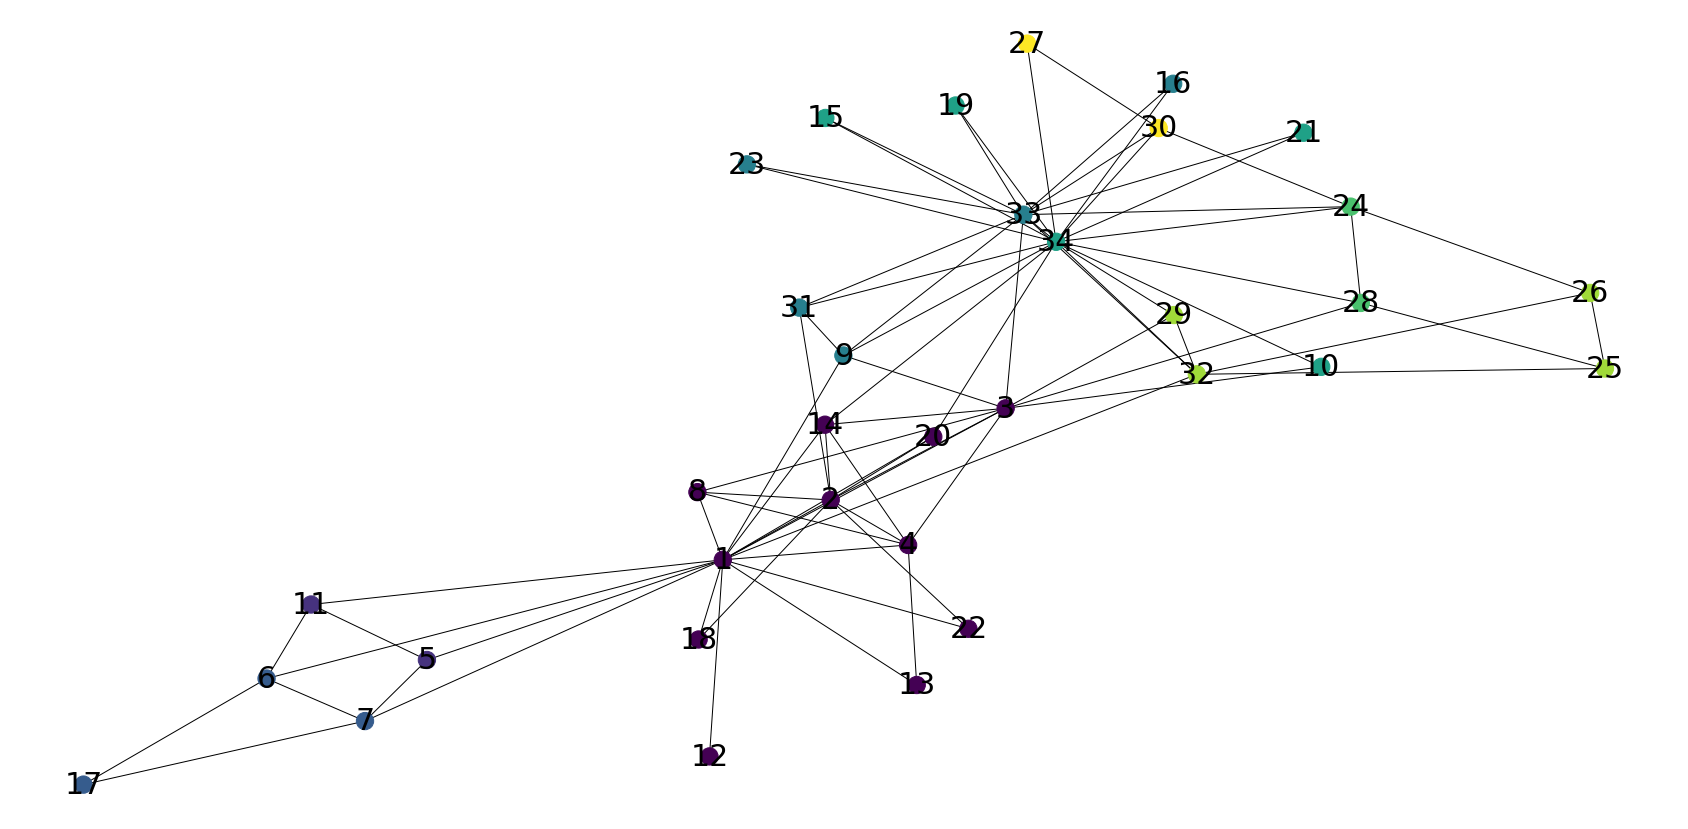

{1: array([ -6.26840804, -12.40218203]),
 2: array([-2.78623636, -7.71660164]),
 3: array([ 2.85867288, -0.5416227 ]),
 4: array([ -0.28883642, -11.24047428]),
 5: array([-15.81638996, -20.24523864]),
 6: array([-20.99079536, -21.69763405]),
 7: array([-17.81420574, -25.02704719]),
 8: array([-7.08731801, -7.1031607 ]),
 9: array([-2.37770019,  3.59343308]),
 10: array([13.04228539,  2.7065779 ]),
 11: array([-19.55504714, -15.90178167]),
 12: array([ -6.69887076, -27.79431355]),
 13: array([-1.14430244e-02, -2.22023007e+01]),
 14: array([-2.97067567, -1.82320997]),
 15: array([-2.95946075, 22.190765  ]),
 16: array([ 8.26449347, 24.86828787]),
 17: array([-26.89933782, -30.        ]),
 18: array([ -7.04888062, -18.64007085]),
 19: array([ 1.24350328, 23.16702456]),
 20: array([ 0.52312849, -2.7700974 ]),
 21: array([12.46776147, 21.03490684]),
 22: array([  1.65664642, -17.80024716]),
 23: array([-5.49098085, 18.55772429]),
 24: array([13.99187251, 15.2494199 ]),
 25: array([22.196886

In [82]:
com = np.array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
        2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2])
G = create_graph(cn._A, cn.communities)
plot_graph(G)

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 10
0 11
0 12
0 13
0 17
0 19
0 21
0 31
1 0
1 2
1 3
1 7
1 13
1 17
1 19
1 21
1 30
2 0
2 1
2 3
2 7
2 8
2 9
2 13
2 27
2 28
2 32
3 0
3 1
3 2
3 7
3 12
3 13
4 0
4 6
4 10
5 0
5 6
5 10
5 16
6 0
6 4
6 5
6 16
7 0
7 1
7 2
7 3
8 0
8 2
8 30
8 32
8 33
9 2
9 33
10 0
10 4
10 5
11 0
12 0
12 3
13 0
13 1
13 2
13 3
13 33
14 32
14 33
15 32
15 33
16 5
16 6
17 0
17 1
18 32
18 33
19 0
19 1
19 33
20 32
20 33
21 0
21 1
22 32
23 25
23 27
23 29
23 32
23 33
24 25
24 27
24 31
25 23
25 24
25 31
26 29
26 33
27 2
27 23
27 24
27 33
28 2
28 31
28 33
29 23
29 26
29 32
29 33
30 1
30 8
30 32
30 33
31 0
31 24
31 25
31 28
31 32
31 33
32 2
32 8
32 14
32 15
32 18
32 20
32 22
32 23
32 29
32 30
32 31
32 33
33 8
33 9
33 13
33 14
33 15
33 18
33 19
33 20
33 23
33 26
33 27
33 28
33 29
33 30
33 31
33 32


In [161]:
a = np.array([0,1.0,2,34],dtype=float)

In [162]:
a

array([ 0.,  1.,  2., 34.])